<a href="https://colab.research.google.com/github/Codeblockz/Data-Science-Self-Projects/blob/main/Kaggle_Titanic_challege/Titanic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Challenge Kaggle <br></br>
[source 1](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)  <br></br>
[source 2]( https://www.kaggle.com/lonnieqin/classification-with-sklearn-and-tensorflow)

## Download Data

In [409]:
# from google.colab import files
# from os.path import exists
# file_exists = exists("/content/kaggle.json")
# if (file_exists==False):
#   files.upload()

In [410]:
%cd /content/drive/MyDrive/Colab Notebooks/Titanic

/content/drive/MyDrive/Colab Notebooks/Titanic


In [411]:
! pip install -q kaggle
!pip install --upgrade kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [412]:
 ! kaggle competitions download titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


Start To work on geting data

In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import string
import copy
from sklearn import preprocessing

In [414]:
# Load Data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/test.csv")
train1 = copy.copy(train)
test1 = copy.copy(test)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check For Nulls


In [415]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [416]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Check Data Types

In [417]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [418]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Data Scrubing 

## Replace NaN

In [419]:
# from source 2
# Replace NAN
# embark_label = train["Embarked"].mode()[0]
# train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
# train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
# train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())

# # Test Replace
# test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
# test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
# test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())

In [420]:
def get_replaced_nan(data):
  embark_label = data["Embarked"].mode()[0]
  data["Cabin"] = data["Cabin"].replace(np.NAN,  "Unknown")
  data["Embarked"] = data["Embarked"].replace(np.NAN, embark_label)
  data["Age"] = data["Age"].replace(np.NAN, data["Age"].mean())
  data["Fare"] = data["Fare"].replace(np.NAN, data["Fare"].mean())
  return data

## Make Title Column

In [421]:
# source 1
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string) # For debug check
    return np.nan
# title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
#             'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
# train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
# test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
# Apply function to data
# train['Title']=train.apply(replace_titles, axis=1)
# test['Title']=test.apply(replace_titles, axis=1)

def get_titles(data):
  title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
  data['Title']=data['Name'].map(lambda x: substrings_in_string(x, title_list))
  data['Title']=data.apply(replace_titles, axis=1)
  return data


In [422]:
# data check
#test.head()

In [423]:
# data check
#train.head()
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Make Cabin Type

In [424]:
# Make cabin type
# Source 2
# train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
# test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# # Make New feature
# train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
# test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

In [425]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [426]:
# data check 
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Make Family Size Type

The correlation bellow shows that Family size is not linearly related however there is a relationship between survival and family size

In [427]:
def convert_faimly_member_size(size):
    if size == 1:
        return "single"
    elif size < 5:
        return "medium"
    else:
        return "large"

In [428]:
# TODO make constant
# should_add_family_member_type = True
# if should_add_family_member_type:
#     for data in [train, test]:
#         data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)

## Make Encoders

In [429]:
# TODO make constant
encode_vals = ['Sex','Cabin_type','Embarked','Title','family_member_type']
VAL = ['Sex','Cabin_type','Embarked','Title','family_member_type']

In [430]:
# make non one hot encoded values
def make_encode_num(data):
  #val = ['Sex','Cabin_type','Embarked','Title','family_member_type']
  for feature in VAL:
    if feature in data.columns:
      data[feature]=data[feature].astype('category')
      data[feature+'_value']=np.int64(data[feature].cat.codes)
  return data
train=make_encode_num(train)
test = make_encode_num(test)

In [431]:
train.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Name                object
Sex               category
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked          category
Sex_value            int64
Embarked_value       int64
dtype: object

In [432]:
# make one hot encoding
# originally named one_hot_tit()
# I only relized after I made the function how bad the naming was
def one_hot(data, original_feature=False):
  for feature in VAL:
    if feature in data.columns:
      temp = data[feature]
      data= pd.get_dummies(data, columns=[feature], dtype=int)
      data.pop(feature+'_value')
      if original_feature == True :
        data[feature]=temp
  return data

## More Functions

In [433]:
def get_data(data, should_add_family_member_type=False):
  # Replace NaNs
  data = get_replaced_nan(data)
  # get titles
  data = get_titles(data)
  # Get Cabin type
  data['Cabin_type'] = data["Cabin"].apply(lambda cabin: cabin[0])
  # Make New feature
  data["family_member_size"] = 1 + data["SibSp"] + data["Parch"]
  # Family memeber
  if should_add_family_member_type:
    data["family_member_type"] = data["family_member_size"].apply(convert_faimly_member_size)
  # encode
  data = make_encode_num(data)
  return data


In [434]:
# make clean up
# Assumes all data in column is same type
# For numeric data
def cleanUp(data):
  for i in data.columns:
    #print(data[i])
    if isinstance(data[i].iloc[0],(np.float, np.integer))==False:
      # print(i)
      data.pop(i)
  data.pop("PassengerId")
  return data 

In [435]:
# number reshape
def getTuple(Value):
  x, y = Value.shape
  z=1
  t = (x,y,z)
  return t 

In [436]:
def get_train_test(data, CC):
  X = data.drop("Survived", axis=1)
  y = data["Survived"]
  #print("X shape: ", X.shape)
  #print(X.values.reshape(891, 27,1))
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  if CC==True:
    X_train=X_train.values
    y_train= y_train.values
    X_val= X_val.values
    y_val=y_val.values
    X_train=np.expand_dims(X_train,axis=2)
    X_val=np.expand_dims(X_val,axis=2)
  return (X_train, X_val, y_train, y_val)

In [437]:
def make_tensor(data):
  X_train, X_val, y_train, y_val = get_train_test(data)
  print("X_train shape: ", X_train.shape)
  print("X_train Type: ", type(X_train))
  print("y_train: ",y_train.shape)
  train_tensor = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
  val_tensor = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
  return train_tensor, val_tensor

In [438]:
# # Testing
# ##################################
# X = copy.copy(OH_train)
# X = X.drop("Survived", axis=1)
# #print("X shape: ", X.shape)
# xshap = X.shape
# x, y = X.shape
# t = (x,y,1)
# #print(t)
# OH_tt, OH_tv = make_tensor(OH_train)
# OH_tt.element_spec


## Apply Functions

### Manual Data Scrub and Format

In [439]:
embark_label = train["Embarked"].mode()[0]
train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())
# Test Replace
test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)
train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# Family Size
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]
# family size type
should_add_family_member_type = True
if should_add_family_member_type:
    for data in [train, test]:
        data["family_member_type"] = train["family_member_size"].apply(convert_faimly_member_size)
train = make_encode_num(train)
test = make_encode_num(test)

### Express Data Scrub and Format

In [440]:
# For Simplicity
train_test = pd.concat([train1,test1])
train_test = get_data(train_test, True)
train = train_test.iloc[0:len(train)]
test = train_test.iloc[len(train):]

In [441]:
# Prepare data for models
# OH stands for one hot
# EN stands for encoded, not one hot
# Use concat to save time
OH_train_test = pd.concat([train,test])
EN_train_test = pd.concat([train, test])
# print shape and size for latter
print("Train Shape: ",train.shape)
print("Train Size: ", len(train))

Train Shape:  (891, 21)
Train Size:  891


In [442]:
# apply OH
# remember to apply with and without family type and size
OH_train_test=one_hot(OH_train_test, False)
OH_train_test = cleanUp(OH_train_test)
OH_train_test["Survived"] = OH_train_test["Survived"].replace(np.NAN, np.int(1))
# Apply EN
EN_train_test = cleanUp(EN_train_test)
EN_train_test["Survived"] = EN_train_test["Survived"].replace(np.NAN, np.int(1))

In [443]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width',None)
pd.set_option('display.max_colwidth', -1)
pd.reset_option("^display")
OH_train_test#

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,Survived,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_female,Sex_male,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_U,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,family_member_type_large,family_member_type_medium,family_member_type_single
0,0.0,3,22.000000,1,0,7.2500,2,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
1,1.0,1,38.000000,1,0,71.2833,2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
2,1.0,3,26.000000,0,0,7.9250,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
3,1.0,1,35.000000,1,0,53.1000,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,0.0,3,35.000000,0,0,8.0500,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1.0,3,29.881138,0,0,8.0500,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
414,1.0,1,39.000000,0,0,108.9000,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
415,1.0,3,38.500000,0,0,7.2500,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
416,1.0,3,29.881138,0,0,8.0500,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1


In [444]:
# Scaling
min_max_scaler = preprocessing.MinMaxScaler()
OH_scaled = min_max_scaler.fit_transform(OH_train_test)
EN_scaled = min_max_scaler.fit_transform(EN_train_test)
OH_train_test = pd.DataFrame(OH_scaled, columns=OH_train_test.columns)
EN_train_test = pd.DataFrame(EN_scaled, columns=EN_train_test.columns)

In [445]:
# train and test
EN_train = EN_train_test.iloc[0:len(train)]
OH_train = OH_train_test.iloc[0:len(train)]
EN_test = EN_train_test.iloc[len(train):]
OH_test = OH_train_test.iloc[len(train):]
EN_test=EN_test.drop("Survived", axis=1)
OH_test = OH_test.drop("Survived", axis=1)

In [446]:
# OH_tt, OH_tv = make_tensor(OH_train)
# EN_tt, EN_tv =make_tensor(EN_train)

In [447]:
# data check
OH_train_test.head()
# OH_train.shape
# OH_tt.element_spec
EN_test

,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
891,1.0,0.430039,0.000,0.000000,0.015282,0.0,1.0,1.00,0.5,0.666667,1.0
892,1.0,0.586622,0.125,0.000000,0.013663,0.1,0.0,1.00,1.0,1.000000,0.5
893,0.5,0.774521,0.000,0.000000,0.018909,0.0,1.0,1.00,0.5,0.666667,1.0
894,1.0,0.336089,0.000,0.000000,0.016908,0.0,1.0,1.00,1.0,0.666667,1.0
895,1.0,0.273456,0.125,0.111111,0.023984,0.2,0.0,1.00,1.0,1.000000,0.5
...,...,...,...,...,...,...,...,...,...,...,...
1304,1.0,0.372180,0.000,0.000000,0.015713,0.0,1.0,1.00,1.0,0.666667,1.0
1305,0.0,0.486409,0.000,0.000000,0.212559,0.0,0.0,0.25,0.0,0.666667,1.0
1306,1.0,0.480145,0.000,0.000000,0.014151,0.0,1.0,1.00,1.0,0.666667,1.0
1307,1.0,0.372180,0.000,0.000000,0.015713,0.0,1.0,1.00,1.0,0.666667,1.0


In [448]:
# data check
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size,family_member_type,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,U,1,single,1,8,1,2,2
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,U,2,medium,0,8,2,3,1
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Mr,U,1,single,1,8,1,2,2
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mr,U,1,single,1,8,2,2,2
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs,U,3,medium,0,8,2,3,1


In [449]:
#temp.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

## Survival Factors

In [450]:
# source 2
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived                    1.000000
Sex_value                  -0.543351
Pclass                     -0.338481
Cabin_type_value           -0.301116
Fare                        0.257307
Embarked_value             -0.167675
family_member_type_value   -0.108631
Parch                       0.081629
Age                        -0.070323
Title_value                -0.062139
SibSp                      -0.035322
family_member_size          0.016639
PassengerId                -0.005007
Name: Survived, dtype: float64

In [451]:
# See what .index Does
# index gives the feature values that equaled true
###########################################################
# l=list(train.corr()[train.corr()["Survived"].abs()>.05] )
# p=list(train.corr()[train.corr()["Survived"].abs()>.05].index )
# print(len(l),"\n",l)
# print(len(p),"\n",p)
# res = [x for x in l + p if x not in l or x not in p]
# print(res)

In [452]:
# Source 2
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value', 'Title_value', 'family_member_type_value']


# Exploratory Data Analysis For Survival

In [453]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   PassengerId               891 non-null    int64   
 1   Survived                  891 non-null    float64 
 2   Pclass                    891 non-null    int64   
 3   Name                      891 non-null    object  
 4   Sex                       891 non-null    category
 5   Age                       891 non-null    float64 
 6   SibSp                     891 non-null    int64   
 7   Parch                     891 non-null    int64   
 8   Ticket                    891 non-null    object  
 9   Fare                      891 non-null    float64 
 10  Cabin                     891 non-null    object  
 11  Embarked                  891 non-null    category
 12  Title                     891 non-null    category
 13  Cabin_type                891 non-null    category

In [454]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value,family_member_type_value
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.735277,0.523008,0.381594,32.204208,1.904602,0.647587,6.716049,1.536476,1.860831,1.533109
std,257.353842,0.486592,0.836071,13.002218,1.102743,0.806057,49.693429,1.613459,0.477990,2.460739,0.791503,0.721066,0.623305
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,8.000000,1.000000,2.000000,1.000000
50%,446.000000,0.000000,3.000000,29.881138,0.000000,0.000000,14.454200,1.000000,1.000000,8.000000,2.000000,2.000000,2.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,8.000000,2.000000,2.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,8.000000,2.000000,3.000000,2.000000


## Survival by Cabin Type

In [455]:
train.groupby("Cabin_type")["Survived"].mean()

Cabin_type
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64

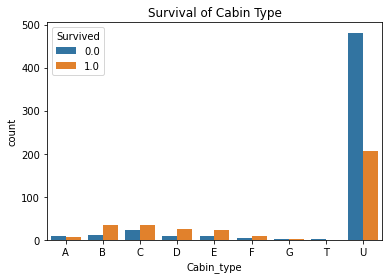

In [456]:
sns.countplot(x="Cabin_type",hue="Survived", data=train)
plt.title("Survival of Cabin Type")
plt.show()

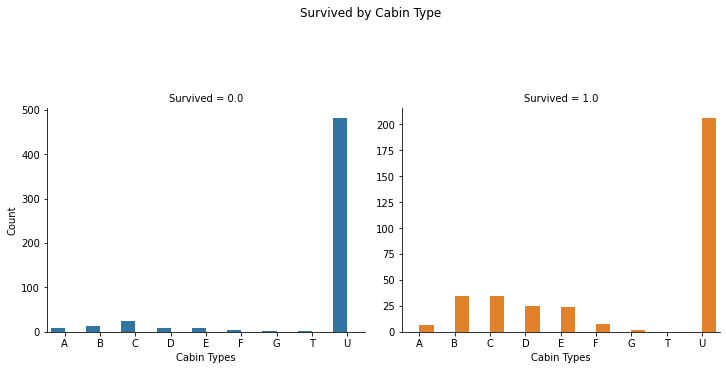

In [457]:
cabin_type_plot= sns.catplot(x="Cabin_type", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
cabin_type_plot.fig.subplots_adjust(top=0.7)
cabin_type_plot.fig.suptitle("Survived by Cabin Type")
cabin_type_plot.set_xlabels("Cabin Types")
cabin_type_plot.set_ylabels("Count")
plt.show()

## Survival by Pclass

In [458]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

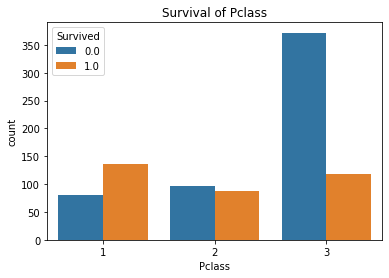

In [459]:
sns.countplot(x="Pclass",hue="Survived", data=train)
plt.title("Survival of Pclass")
plt.show()

## Survival by Sex

In [460]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

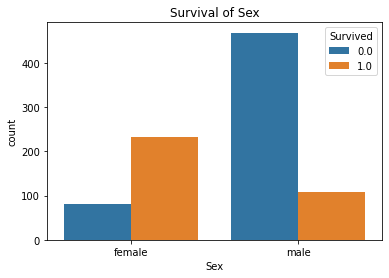

In [461]:
sns.countplot(x="Sex",hue="Survived", data=train)
plt.title("Survival of Sex")
plt.show()

## Survival by Age

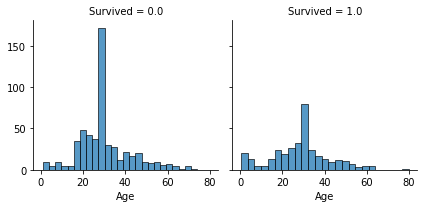

In [462]:
sns.FacetGrid(train, col="Survived").map(sns.histplot, "Age", bins=25)
plt.show()

## Survial by Sibsp

In [463]:
train.groupby("SibSp")["Survived"].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

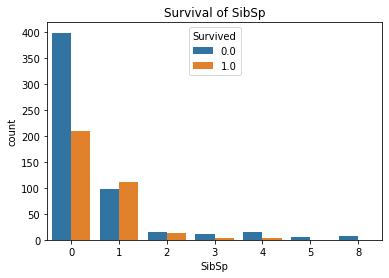

In [464]:
sns.countplot(x="SibSp",hue="Survived", data=train)
plt.title("Survival of SibSp")
plt.show()

## Survival by Parch

In [465]:
train.groupby("Parch")["Survived"].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

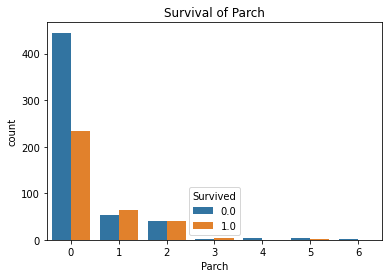

In [466]:
sns.countplot(x="Parch",hue="Survived", data=train)
plt.title("Survival of Parch")
plt.show()


## Survival by Fare


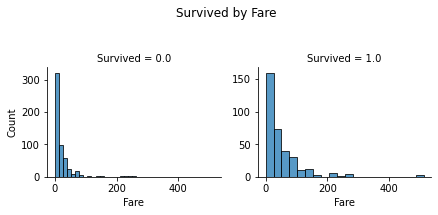

In [467]:
Fare_plot=sns.FacetGrid(train, col="Survived", sharey=False)
Fare_plot.map(sns.histplot, "Fare",bins=20)
Fare_plot.fig.subplots_adjust(top=0.7)
Fare_plot.fig.suptitle("Survived by Fare")
Fare_plot.set_xlabels("Fare")
Fare_plot.set_ylabels("Count")
plt.show()

## Survival by Embarked


In [468]:
train.groupby("Embarked")["Survived"].mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

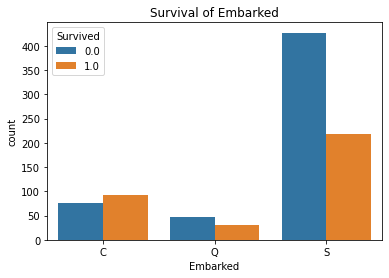

In [469]:
sns.countplot(x="Embarked",hue="Survived",data=train)
plt.title("Survival of Embarked")
plt.show()

## Survived by Title

In [470]:
train.groupby("Title")["Survived"].mean()

Title
Master    0.575000
Miss      0.703297
Mr        0.158192
Mrs       0.775362
Name: Survived, dtype: float64

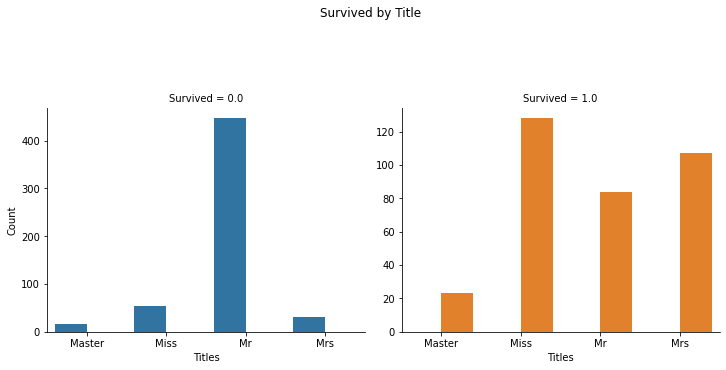

In [471]:
title_plot= sns.catplot(x="Title", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
title_plot.fig.subplots_adjust(top=0.7)
title_plot.fig.suptitle("Survived by Title")
title_plot.set_xlabels("Titles")
title_plot.set_ylabels("Count")
plt.show()

In [472]:
train.max()

PassengerId                                         891
Survived                                              1
Pclass                                                3
Name                        van Melkebeke, Mr. Philemon
Age                                                  80
SibSp                                                 8
Parch                                                 6
Ticket                                        WE/P 5735
Fare                                            512.329
Cabin                                           Unknown
family_member_size                                   11
Sex_value                                             1
Cabin_type_value                                      8
Embarked_value                                        2
Title_value                                           3
family_member_type_value                              2
dtype: object

# Models

## DNN Model

In [473]:
#OH_tt

In [474]:
## testing
X_train, X_val, y_train, y_val = get_train_test(OH_train, True)
# X_train=X_train.values
# y_train= y_train.values
# X_val= X_val.values
# y_val=y_val.values
# X_train=np.expand_dims(X_train,axis=2)
# X_val=np.expand_dims(X_val,axis=2)

print("X_val.shape: ",X_val.shape)
print("y_val.shape: ",y_val.shape)
print("X_train.shape: ",X_train.shape)
print("y_train.shape: ",y_train.shape)

X_val.shape:  (179, 27, 1)
y_val.shape:  (179,)
X_train.shape:  (712, 27, 1)
y_train.shape:  (712,)


In [475]:
#def makeCN_Model():
  #model_input = Input(shape=(27, 1))
model = tf.keras.Sequential([
#tf.keras.layers.Input(27,1),
tf.keras.layers.Conv1D(128, 5, activation='relu',input_shape=(27,1)),
tf.keras.layers.MaxPooling1D(pool_size=2),
tf.keras.layers.Conv1D(128, 4, activation='relu'),
tf.keras.layers.MaxPooling1D(pool_size=2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(100, activation="relu"),
tf.keras.layers.Dense(50, activation="relu"),
tf.keras.layers.Dense(1, activation='sigmoid')
])
  #return model
#OHCN_model=makeCN_Model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 23, 128)           768       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 128)            65664     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_28 (Dense)             (None, 50)               

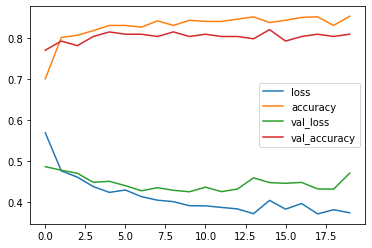

In [476]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history=OHCN_model.fit()
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
history = model.fit(
    X_train, y_train,epochs=400, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [477]:
model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 3ms/step - loss: 0.4707 - accuracy: 0.8101


[0.4706823229789734, 0.8100558519363403]

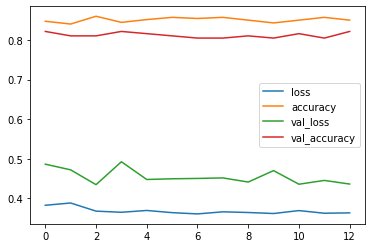

In [478]:

history = model.fit(
    X_train, y_train,epochs=400, 
    validation_data=(X_val,y_val), 
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [479]:
# The inputs are 128-length vectors with 10 timesteps, and the batch size
# is 4.
# input_shape = (4, 10, 128)
# x = tf.random.normal(input_shape)
# y = tf.keras.layers.Conv1D(
# 32, 3, activation='relu',input_shape=input_shape[1:])(x)
# print(y.shape) 
# input_shape = OH_tt
# x = tf.random.normal((1,27))
# model=0
# # y = tf.keras.layers.Conv1D(
# # 32, 2, activation='relu',input_dim=27)(x)
# y = tf.keras.layers.Conv1D(
# 34,activation='relu',input_shape=input_shape, kernel_size=5)(x)
# print(y.shape)

## Deep and Wide Model

In [480]:
categorical_feature_names = ["Pclass", "Sex_value", "Embarked_value", "Cabin_type_value"]
numerical_feature_names = ["Age", "Fare", "SibSp", "Parch", "family_member_size"]
categorical_features = [
    feature_column.indicator_column(
        feature_column.categorical_column_with_vocabulary_list(key, sorted(list(train[key].unique())))
    ) for key in categorical_feature_names
]
print(categorical_features)
numerical_features = [feature_column.numeric_column(key) for key in numerical_feature_names]
input_dictionary = dict()
inputs = dict()
for item in numerical_features:
    inputs[item.key] = tf.keras.layers.Input(name=item.key, shape=())
for item in categorical_features:
    #print(item.categorical_column.key)
    inputs[item.categorical_column.key] = tf.keras.layers.Input(name=item.categorical_column.key, shape=(), dtype="int32")

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex_value', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Embarked_value', vocabulary_list=(0, 1, 2), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Cabin_type_value', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0))]


In [481]:
# Source 2 
# Helper Features
def features_and_labels(row_data):
    label = row_data.pop("Survived")
    features = row_data
    # print("Label: ", label)
    # print("Feature: ", features)
    return features, label

def create_dataset(pattern, epochs=1, batch_size=32, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    # print("Before map: ", dataset)
    dataset = dataset.map(features_and_labels)
    # print("After map: ",dataset)
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=128).repeat(epochs)
    #print(dataset)
    dataset = dataset.prefetch(1)
    #print("after prefetch\n",dataset)
    return dataset

def create_test_dataset(pattern, batch_size=32):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(lambda features: features)
    dataset = dataset.prefetch(1)
    return dataset

In [482]:
# Train test split
train_data, val_data = train_test_split(
    train[categorical_feature_names + numerical_feature_names + ["Survived"]],
    test_size=.2,
    random_state=np.random.randint(0, 1000)
)
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test[categorical_feature_names + numerical_feature_names].to_csv("test_data.csv", index=False)
batch_size = 32
train_dataset = create_dataset("train_data.csv", batch_size=batch_size, mode='train')
val_dataset = create_dataset("val_data.csv", batch_size=val_data.shape[0], mode='eval').take(1)
test_dataset = create_test_dataset("test_data.csv", batch_size = test.shape[0]).take(1)

In [483]:
# D&W Model
def build_deep_and_wide_model():
    deep = tf.keras.layers.DenseFeatures(numerical_features, name='deep')(inputs)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    wide = tf.keras.layers.DenseFeatures(categorical_features, name='wide')(inputs)
    wide = tf.keras.layers.Dense(32, activation='relu')(wide)
    combined = tf.keras.layers.concatenate(inputs=[deep, wide], name='combined')
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

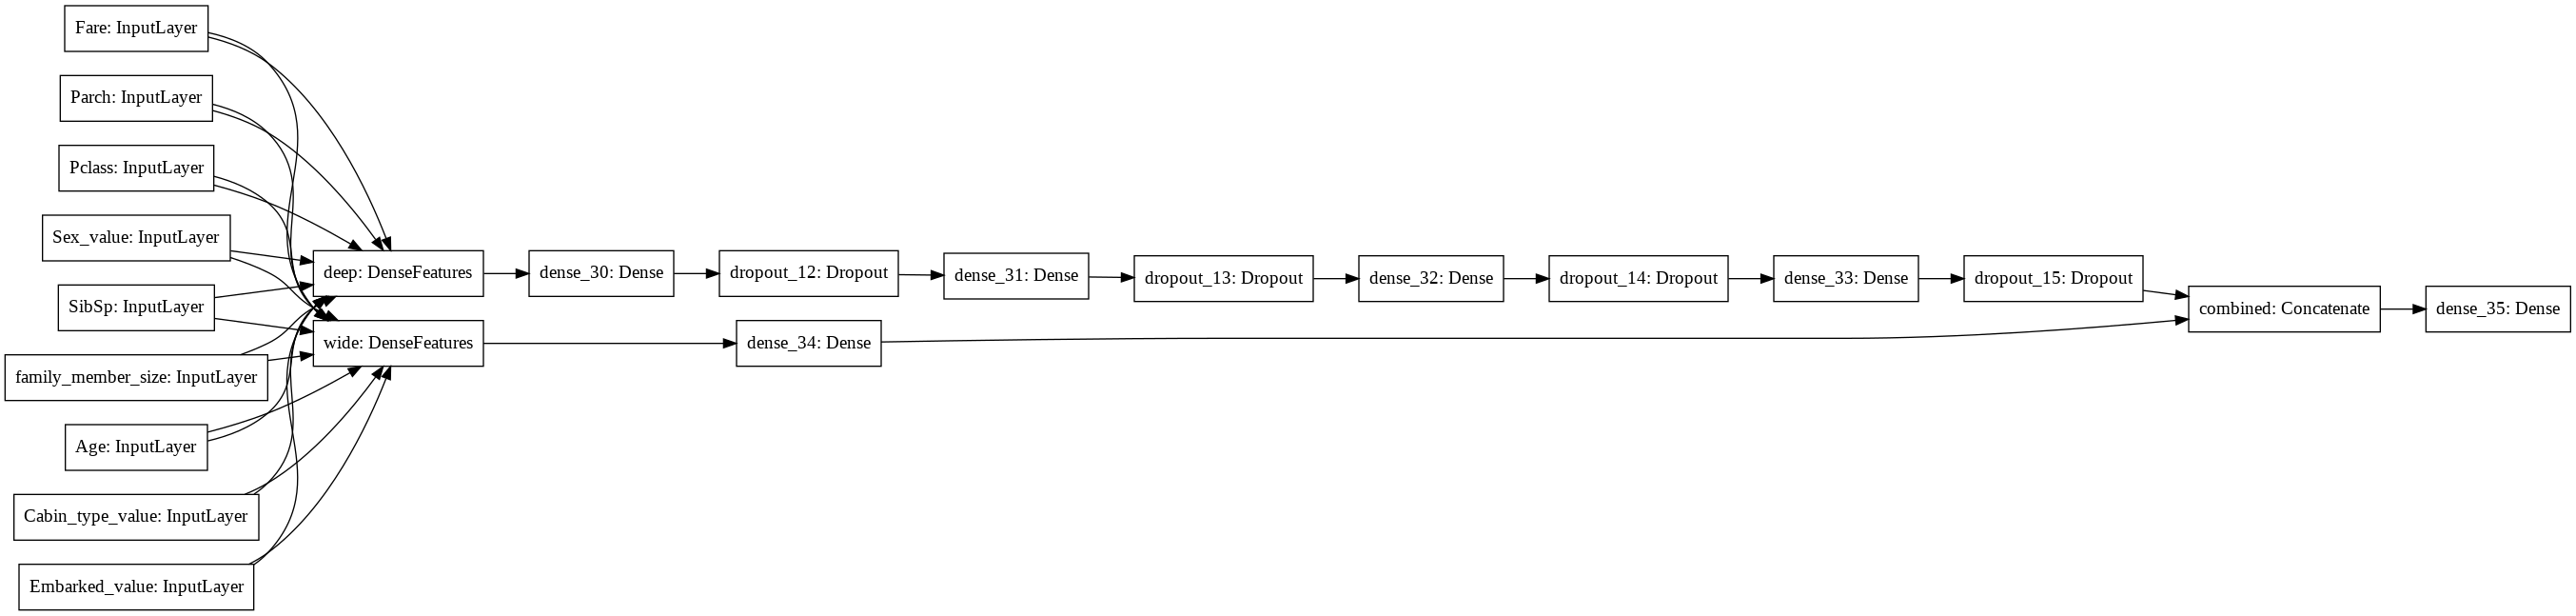

In [484]:
deep_and_wide_model = build_deep_and_wide_model()
tf.keras.utils.plot_model(deep_and_wide_model, show_shapes=False, rankdir='LR')

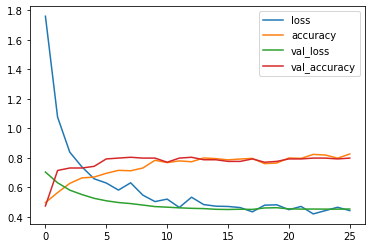

In [485]:
epochs = 400
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
steps_per_epoch = train_data.shape[0] // batch_size
history = deep_and_wide_model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [486]:
# y_pred =  np.array(deep_and_wide_model.predict(val_dataset) > 0.5, dtype=int).reshape(-1)
y_pred = np.array(deep_and_wide_model.predict(val_dataset)>0.5,dtype=int).reshape(-1)
score = accuracy_score(val_data["Survived"], y_pred)
print("Accuraccy Score: ",score)
print(sklearn.metrics.classification_report(val_data["Survived"], y_pred))
Survived = np.argmax(deep_and_wide_model.predict(test_dataset), axis=-1).reshape(-1)
# print(np.argmax(deep_and_wide_model.predict(test_dataset),axis=1).reshape(-1))
# print(test.shape)
print(Survived.shape)

Accuraccy Score:  0.5307262569832403
              precision    recall  f1-score   support

         0.0       0.63      0.68      0.66       118
         1.0       0.28      0.25      0.26        61

    accuracy                           0.53       179
   macro avg       0.46      0.46      0.46       179
weighted avg       0.51      0.53      0.52       179

(418,)
